In [97]:
# BERT Text Classification using Keras

# py37TF2 - home-imac

In [98]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
import keras
from tqdm import tqdm
import pickle
from keras.models import Model
import keras.backend as K
from sklearn.metrics import confusion_matrix,f1_score,classification_report
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
import itertools
from keras.models import load_model
from sklearn.utils import shuffle
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig

In [99]:

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def clean_stopwords_shortwords(w):
    stopwords_list=stopwords.words('english')
    words = w.split() 
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 2]
    return " ".join(clean_words) 

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w=clean_stopwords_shortwords(w)
    w=re.sub(r'@\w+', '',w)
    return w

In [100]:
data = pd.read_csv('./data_political_compass/political_compass_datasets.csv')

In [101]:
data.head()

,Unnamed: 0,text,label
0,0,ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...,center
1,1,They told Reuter correspondents in Asian capit...,center
2,2,But some exporters said that while the conflic...,center
3,3,The U.S. Has said it will impose 300 mln dlrs ...,center
4,4,Unofficial Japanese estimates put the impact o...,center


In [102]:
print('File has {} rows and {} columns'.format(data.shape[0],data.shape[1]))

File has 1548 rows and 3 columns


In [103]:
# Select required columns
data = data[['text', 'label']]

In [104]:
data.head()

,text,label
0,ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...,center
1,They told Reuter correspondents in Asian capit...,center
2,But some exporters said that while the conflic...,center
3,The U.S. Has said it will impose 300 mln dlrs ...,center
4,Unofficial Japanese estimates put the impact o...,center


In [105]:
# Remove rows, where the label is present only ones (can't be split)
data = data.groupby('label').filter(lambda x : len(x) > 1)
#data = data.groupby('Product').filter(lambda x : len(x) > 1)

In [106]:
data.head()

,text,label
0,ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...,center
1,They told Reuter correspondents in Asian capit...,center
2,But some exporters said that while the conflic...,center
3,The U.S. Has said it will impose 300 mln dlrs ...,center
4,Unofficial Japanese estimates put the impact o...,center


In [107]:
# shaffle datasets
data = data.sample(frac=1).reset_index(drop=True)
data

,text,label
0,Is he trying to help Netanyahu win?,lean_left
1,(Sunday Alamba/AP,left
2,This has allowed France to sketch the way out ...,left
3,And he's also trying to play up his status as ...,lean_left
4,Yeah.,lean_left
...,...,...
1543,(Chris McGrath/Getty Images)\nBrazil\nBrazilia...,left
1544,And so it's still going to be a very long uphi...,lean_left
1545,And there were people in social media that sai...,lean_left
1546,And in a country like Uruguay that went throug...,lean_left


In [108]:
data=data.dropna()                                                           # Drop NaN valuues, if any
data=data.reset_index(drop=True)                                             # Reset index after dropping the columns/rows with NaN values
data = shuffle(data)                                                         # Shuffle the dataset
print('Available labels: ',data.label.unique())                              # Print all the unique labels in the dataset
data['text']=data['text'].map(preprocess_sentence)                           # Clean the text column using preprocess_sentence function defined above

Available labels:  ['lean_left' 'right' 'left' 'center' 'lean_right']


In [109]:

print('File has {} rows and {} columns'.format(data.shape[0],data.shape[1]))
data.head()

File has 1548 rows and 2 columns


,text,label
234,election materials distributed speak,lean_left
208,annual deficits rise since big spike amid pand...,right
570,young queer immigrant woman united states real...,lean_left
1506,like really,lean_left
347,justice department charged least hundred peopl...,left


In [110]:
num_classes=len(data.label.unique())
num_classes

5

In [111]:

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=num_classes)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [112]:

sent= 'how to train the model, lets look at how a trained model calculates its prediction.'
tokens=bert_tokenizer.tokenize(sent)
print(tokens)

['how', 'to', 'train', 'the', 'model', ',', 'lets', 'look', 'at', 'how', 'a', 'trained', 'model', 'calculate', '##s', 'its', 'prediction', '.']


In [113]:
tokenized_sequence= bert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =30,pad_to_max_length = True,
return_attention_mask = True)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/kimkwangil/opt/anaconda3/envs/py38pytorch/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2104: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [114]:

tokenized_sequence

{'input_ids': [101, 2129, 2000, 3345, 1996, 2944, 1010, 11082, 2298, 2012, 2129, 1037, 4738, 2944, 18422, 2015, 2049, 17547, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [115]:
bert_tokenizer.decode(tokenized_sequence['input_ids'])

'[CLS] how to train the model, lets look at how a trained model calculates its prediction. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [116]:
data['gt'] = data['label'].map({'left':0,'lean_left':1, 'center':2,'lean_right':3, 'right':4})
data.head()

,text,label,gt
234,election materials distributed speak,lean_left,1
208,annual deficits rise since big spike amid pand...,right,4
570,young queer immigrant woman united states real...,lean_left,1
1506,like really,lean_left,1
347,justice department charged least hundred peopl...,left,0


In [117]:

sentences=data['text']
labels=data['gt']
len(sentences),len(labels)

(1548, 1548)

# 문장을 숫자변환 예

- Original Sentence: Let's learn deep learning!

- Tokenized Sentence: ['Let', "'", 's', 'learn', 'deep', 'learning', '!']

- Adding [CLS] and [SEP] Tokens: ['[CLS]', 'Let', "'", 's', 'learn', 'deep', 'learning', '!', '[SEP]']

- Padding: ['[CLS]', 'Let', "'", 's', 'learn', 'deep', 'learning', '!', '[SEP]', '[PAD]']

- Converting to IDs: [101, 2421, 112, 188, 3858, 1996, 3776, 106, 102, 0]

In [118]:
input_ids=[] # 입력데디터 리스트 선언
attention_masks=[] # 앞뒤 정보를 비교하여 마스크 예측하기 위한 리스트 선언

for sent in sentences: # 문장하나씩 가져와서 인풋, 마스스크를 추가
    # 문장을 숫자로 바꾼다. 짧은 문장은 패딩처리하고, 토큰화 한다.
    bert_inp=bert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =64,pad_to_max_length = True,return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)

/Users/kimkwangil/opt/anaconda3/envs/py38pytorch/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2104: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [119]:
input_ids

array([[  101,  2602,  4475, ...,     0,     0,     0],
       [  101,  3296, 15074, ...,  4551,  4675,   102],
       [  101,  2402, 19483, ...,     0,     0,     0],
       ...,
       [  101,  2360,  7714, ...,     0,     0,     0],
       [  101, 11434,  7325, ...,     0,     0,     0],
       [  101,  7226,  2368, ...,     0,     0,     0]])

In [120]:
attention_masks

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [121]:
labels

array([1, 4, 1, ..., 1, 1, 4])

In [122]:
len(input_ids),len(attention_masks),len(labels)

(1548, 1548, 1548)

In [123]:

print('Preparing the pickle file.....')

pickle_inp_path='./data_pc/bert_inp.pkl'
pickle_mask_path='./data_pc/bert_mask.pkl'
pickle_label_path='./data_pc/bert_label.pkl'

pickle.dump((input_ids),open(pickle_inp_path,'wb'))
pickle.dump((attention_masks),open(pickle_mask_path,'wb'))
pickle.dump((labels),open(pickle_label_path,'wb'))


print('Pickle files saved as ',pickle_inp_path,pickle_mask_path,pickle_label_path)

Preparing the pickle file.....
Pickle files saved as  ./data_pc/bert_inp.pkl ./data_pc/bert_mask.pkl ./data_pc/bert_label.pkl


In [124]:
print('Loading the saved pickle files..')

input_ids=pickle.load(open(pickle_inp_path, 'rb'))
attention_masks=pickle.load(open(pickle_mask_path, 'rb'))
labels=pickle.load(open(pickle_label_path, 'rb'))

print('Input shape {} Attention mask shape {} Input label shape {}'.format(input_ids.shape,attention_masks.shape,labels.shape))

Loading the saved pickle files..
Input shape (1548, 64) Attention mask shape (1548, 64) Input label shape (1548,)


In [125]:
input_ids # 입력문장

array([[  101,  2602,  4475, ...,     0,     0,     0],
       [  101,  3296, 15074, ...,  4551,  4675,   102],
       [  101,  2402, 19483, ...,     0,     0,     0],
       ...,
       [  101,  2360,  7714, ...,     0,     0,     0],
       [  101, 11434,  7325, ...,     0,     0,     0],
       [  101,  7226,  2368, ...,     0,     0,     0]])

In [126]:
attention_masks # 마스크처리된 데이터

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [127]:
labels # 문장당 레이블(5 가지 척도)

array([1, 4, 1, ..., 1, 1, 4])

In [128]:
train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids,labels,attention_masks,test_size=0.2)

print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape,val_inp.shape,train_label.shape,val_label.shape,train_mask.shape,val_mask.shape))

Train inp shape (1238, 64) Val input shape (310, 64)
Train label shape (1238,) Val label shape (310,)
Train attention mask shape (1238, 64) Val attention mask shape (310, 64)


In [129]:
# 예측에 사용하는 데이터

# input_ids : val_inp    --> 입력문장
# val_mask --> 마스크처리된 단어

In [130]:
val_inp

array([[  101, 19089,  7299, ...,     0,     0,     0],
       [  101, 17069,  7108, ...,     0,     0,     0],
       [  101,  2204,  3160, ...,     0,     0,     0],
       ...,
       [  101,  2567,  2165, ...,     0,     0,     0],
       [  101,  2343,  2036, ...,     0,     0,     0],
       [  101,  2402, 19483, ...,     0,     0,     0]])

In [131]:
val_inp.shape

(310, 64)

In [132]:
val_label

array([1, 3, 1, 0, 3, 0, 4, 1, 1, 0, 1, 4, 1, 1, 0, 1, 4, 1, 1, 1, 3, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 4, 4, 1, 1, 0, 0, 1, 0, 4, 1, 1, 4, 1, 4,
       1, 0, 0, 1, 1, 1, 3, 4, 1, 1, 0, 1, 1, 1, 1, 0, 0, 4, 0, 2, 1, 0,
       3, 3, 0, 0, 3, 1, 1, 0, 4, 3, 1, 0, 4, 0, 0, 0, 1, 1, 1, 0, 1, 2,
       4, 0, 4, 1, 4, 1, 0, 1, 1, 1, 4, 0, 0, 1, 4, 1, 1, 1, 0, 0, 1, 4,
       0, 1, 1, 0, 0, 0, 1, 0, 4, 2, 4, 1, 1, 1, 0, 1, 0, 4, 0, 1, 1, 1,
       4, 0, 1, 1, 4, 1, 1, 4, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 2, 1, 1, 0, 1, 4, 0, 0, 0, 4, 0, 1, 0, 4, 4, 0, 1, 4, 1, 4,
       0, 1, 0, 1, 0, 4, 0, 1, 0, 3, 1, 4, 1, 0, 4, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 2, 2, 1, 1, 1, 4, 1, 0, 0, 1, 1, 1, 1, 4, 1,
       1, 1, 1, 1, 0, 1, 1, 4, 0, 1, 0, 1, 4, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       3, 4, 0, 4, 1, 4, 0, 0, 1, 2, 4, 0, 1, 1, 1, 1, 1, 1, 0, 2, 4, 1,
       1, 1, 1, 0, 4, 1, 1, 2, 1, 0, 4, 0, 0, 1, 1, 1, 0, 0, 4, 3, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 4, 0, 0, 1, 1, 1, 4, 0,

In [133]:
val_label.shape

(310,)

In [134]:
val_mask

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [135]:
val_mask.shape

(310, 64)

In [136]:
log_dir='tensorboard_data/tb_bert'
model_save_path='./models/bert_model.h5'

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir)]

print('\nBert Model',bert_model.summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

bert_model.compile(loss=loss,optimizer=optimizer,metrics=[metric])


Model: "tf_bert_for_sequence_classification_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_113 (Dropout)        multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  3845      
Total params: 109,486,085
Trainable params: 109,486,085
Non-trainable params: 0
_________________________________________________________________

Bert Model None


In [163]:

history=bert_model.fit([train_inp,train_mask],train_label,batch_size=32,epochs=40,validation_data=([val_inp,val_mask],val_label),callbacks=callbacks)

Epoch 1/40
39/39 [==============================] - 168s 4s/step - loss: 0.0076 - accuracy: 0.9984 - val_loss: 1.1775 - val_accuracy: 0.8129
Epoch 2/40
39/39 [==============================] - 166s 4s/step - loss: 0.0144 - accuracy: 0.9968 - val_loss: 1.3094 - val_accuracy: 0.7935
Epoch 3/40
39/39 [==============================] - 167s 4s/step - loss: 0.0141 - accuracy: 0.9968 - val_loss: 1.2033 - val_accuracy: 0.8065
Epoch 4/40
39/39 [==============================] - 167s 4s/step - loss: 0.0164 - accuracy: 0.9968 - val_loss: 1.2763 - val_accuracy: 0.7806
Epoch 5/40
39/39 [==============================] - 164s 4s/step - loss: 0.0132 - accuracy: 0.9968 - val_loss: 1.1506 - val_accuracy: 0.7806
Epoch 6/40
39/39 [==============================] - 162s 4s/step - loss: 0.0041 - accuracy: 0.9992 - val_loss: 1.2209 - val_accuracy: 0.7935
Epoch 7/40
39/39 [==============================] - 159s 4s/step - loss: 0.0043 - accuracy: 0.9992 - val_loss: 1.2551 - val_accuracy: 0.7968
Epoch 8/40
39

In [140]:

model_save_path='./models/bert_model.h5'

trained_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=5)
trained_model.compile(loss=loss,optimizer=optimizer, metrics=[metric])
trained_model.load_weights(model_save_path)

preds = trained_model.predict([val_inp,val_mask],batch_size=32)
print('preds:', preds)
print(type(preds))
preds = preds['logits']
print('preds_:', preds)
# import numpy as np
# pred_labels = np.argmax(preds)
pred_labels = preds.argmax(axis=1)
print('pred_labels', pred_labels)
print('val_label', val_label)

f1 = f1_score(val_label,pred_labels, average='micro')
print('F1 score',f1)
print('Classification Report')
target_names = ['left', 'lean_left', 'center', 'lean_right', 'right']
print(classification_report(val_label,pred_labels,target_names=target_names))

print('Training and saving built model.....')

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preds: TFSequenceClassifierOutput(loss=None, logits=array([[-0.10019217,  3.277342  , -1.8268948 , -1.0012113 , -1.2440035 ],
       [ 0.5970513 , -1.4175588 , -0.5475062 ,  0.5165085 ,  1.2253442 ],
       [-0.79382205,  3.9933996 , -1.5498416 , -1.1479626 , -1.1485069 ],
       ...,
       [-0.4367331 , -1.3278909 , -0.24322936, -0.65558124,  3.3821518 ],
       [-0.82193136,  4.0403714 , -1.627385  , -1.1108896 , -1.213926  ],
       [-0.99730295,  3.9718273 , -1.480455  , -0.78265995, -1.3801324 ]],
      dtype=float32), hidden_states=None, attentions=None)
<class 'transformers.modeling_tf_outputs.TFSequenceClassifierOutput'>
preds_: [[-0.10019217  3.277342   -1.8268948  -1.0012113  -1.2440035 ]
 [ 0.5970513  -1.4175588  -0.5475062   0.5165085   1.2253442 ]
 [-0.79382205  3.9933996  -1.5498416  -1.1479626  -1.1485069 ]
 ...
 [-0.4367331  -1.3278909  -0.24322936 -0.65558124  3.3821518 ]
 [-0.82193136  4.0403714  -1.627385   -1.1108896  -1.213926  ]
 [-0.99730295  3.9718273  -1.48045

In [164]:

# sentnece label : lean_left

sent_input = """One Metropolitan Police officer who was beaten and tased during the riot, Michael Fanone, has advocated for the release of his body camera video and repeatedly criticized Republicans who've tried to downplay the violence during the insurrection."""



# 문장을 숫자로 바꾼다. 짧은 문장은 패딩처리하고, 토큰화 한다.
bert_inp=bert_tokenizer.encode_plus(sent_input,add_special_tokens = True,max_length =64,pad_to_max_length = True,return_attention_mask = True)
input_ids=bert_inp['input_ids']
attention_masks= bert_inp['attention_mask']

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)

/Users/kimkwangil/opt/anaconda3/envs/py38pytorch/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2104: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [165]:
bert_inp

{'input_ids': [101, 2028, 4956, 2610, 2961, 2040, 2001, 7854, 1998, 11937, 6924, 2076, 1996, 11421, 1010, 2745, 5470, 5643, 1010, 2038, 11886, 2005, 1996, 2713, 1997, 2010, 2303, 4950, 2678, 1998, 8385, 6367, 10643, 2040, 1005, 2310, 2699, 2000, 2091, 13068, 1996, 4808, 2076, 1996, 27860, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [166]:
input_ids

array([  101,  2028,  4956,  2610,  2961,  2040,  2001,  7854,  1998,
       11937,  6924,  2076,  1996, 11421,  1010,  2745,  5470,  5643,
        1010,  2038, 11886,  2005,  1996,  2713,  1997,  2010,  2303,
        4950,  2678,  1998,  8385,  6367, 10643,  2040,  1005,  2310,
        2699,  2000,  2091, 13068,  1996,  4808,  2076,  1996, 27860,
        1012,   102,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])

In [167]:
attention_masks

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [168]:
# val_inp : input_ids
# val_mask : attention_masks

preds = trained_model.predict([input_ids,attention_masks],batch_size=32)
preds = preds['logits'] # 시그모이드함수 적용하여 데이터의 결과를 두 그룹으로 분류해본다. 0 or 1
print("prieds'logit':", preds)
pred_labels = preds.argmax(axis=1)
print('pred_labels', pred_labels)

prieds'logit': [[-8.90707895e-02  8.98056269e-01 -7.82368422e-01  9.19078384e-03
  -1.04985535e-02]
 [-5.93817949e-01  3.11751366e-01 -5.00535607e-01  3.50615621e-01
   5.29220700e-01]
 [ 2.74580806e-01  5.24960220e-01 -5.69562256e-01 -1.93253845e-01
   2.27115750e-01]
 [ 2.44317129e-01 -3.41308504e-01 -4.84494448e-01  1.57527119e-01
   8.65527391e-01]
 [ 2.98400617e+00 -4.80385453e-01 -1.17800677e+00 -6.03118062e-01
  -9.27470982e-01]
 [-4.14292186e-01  4.62470293e-01 -5.86642444e-01  3.22460592e-01
  -9.53811854e-02]
 [ 4.45126683e-01  1.12296057e+00 -1.03421831e+00 -5.12869596e-01
  -5.33288002e-01]
 [ 1.66035426e+00  2.98524261e-01 -9.57270503e-01 -3.95771295e-01
  -3.22747231e-01]
 [-4.70789760e-01  1.71383485e-01 -4.66621518e-01  6.97866082e-02
   8.23069930e-01]
 [-3.91584307e-01  9.19466853e-01 -7.16929793e-01 -9.84509438e-02
   3.53675485e-01]
 [ 2.55003977e+00 -7.24218130e-01 -4.74880010e-01 -6.92291498e-01
  -1.17981768e+00]
 [-6.61817610e-01  1.28744805e+00 -6.30556941e-01 

In [169]:
type(pred_labels)

numpy.ndarray

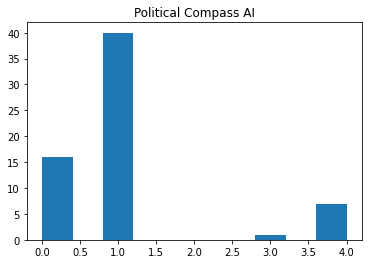

In [170]:
plt.hist(pred_labels)

plt.title("Political Compass AI")


plt.show()

In [171]:
result = np.bincount(pred_labels)
result = np.argmax(result)
result

1

In [172]:
def get_political_compass(result):
    if result == 0:
        print('Left')
        result = 'Left'
    elif result == 1:
        print('Lean_Left')
        result = 'Lean_Left'
    elif result == 2:
        print('Center')
        result = 'Center'
    elif reulst == 3:
        print('Lean_Right')
        result = 'Lean_Right'
    else:
        print('Right')
        result = 'Right'
    return result

In [173]:
Final_Result = get_political_compass(result)

Lean_Left
